In [141]:
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue
from astropy.io import fits
from numba import njit
import os
import pandas as pd

In [2]:
c = 0 #2989, 5987, 9117, 12082
dimmax = 0
size_cut_off = 5

In [3]:
def load_file(i:int) -> np.array:
    if (i > 4) or (i<0):
        i = 3
    hdul = fits.open(f'data/Image10466{i}.fits')
    return hdul[0].data[40:4124,5:2040]

def gen_binary(i:int = 0, limit:int = 4000) -> np.array:
    data = load_file(i)
    data[data < limit] = 0
    data[data >= limit] = 1
    return data

def gen_colour(i:int = 0) -> np.array:
    data = load_file(i)
    return data

def check_nbors(i,j, queue):
    global w,h
    n_bors = [(-1,-1), (-1,0), (-1,1),
              ( 0,-1),         ( 0,1),
              ( 1,-1), ( 1,0), ( 1,1)]
    for n in n_bors:
        n_bor = (n[0]+i,n[1]+j)
        # Is n_bor on grid?
        if (n_bor[0]<0) or (n_bor[0]==h) or (n_bor[1]<0) or (n_bor[1]==w):
            continue
        if (data[n_bor]>0)&(clusters[n_bor]==-1):
            clusters[n_bor] = clusters[i,j]
            queue.put(n_bor)

In [4]:
file = 3
data = gen_binary(file)

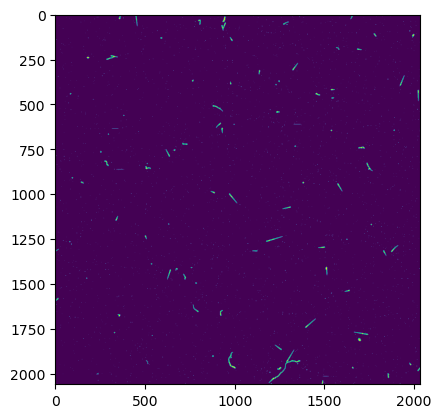

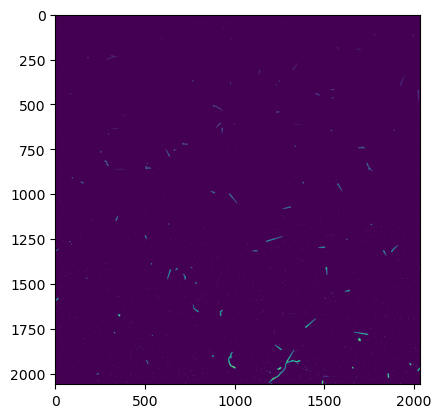

In [5]:
plt.imshow(data)

h,w = data.shape
plt.show()


clusters = -1* np.ones_like(data)
    
queue = Queue()
for i in range(h):
    for j in range(w):
        if (clusters[i,j]==-1)&(data[i,j]>0):
            clusters[i,j] = c
            c+=1
            check_nbors(i,j,queue)
        while not queue.empty():
            check_nbors(*queue.get(),queue)
plt.imshow(clusters)

In [57]:
def calc_square(index:int,clusters:np.array):
    imax,jmax = clusters.shape
    active_inds = np.argwhere(clusters == index).T
    picture =  clusters[np.min(active_inds[0]):np.max(active_inds[0])+1,
                    np.min(active_inds[1]):np.max(active_inds[1])+1]
    return picture==index #Return binary

def calc_square_colour(index:int, clusters:np.array, data:np.array,
                      limit:int = 4000):
    imax,jmax = clusters.shape
    active_inds = np.argwhere(clusters == index).T
    picture =  data[np.min(active_inds[0]):np.max(active_inds[0])+1,
                    np.min(active_inds[1]):np.max(active_inds[1])+1]
    pic_bin = clusters[np.min(active_inds[0]):np.max(active_inds[0])+1,
                    np.min(active_inds[1]):np.max(active_inds[1])+1]
    picture[ pic_bin != index]  = limit
    return picture

def save_pic(pic:np.array,fname:str,size:int=None, path:str = "clusters"):
    #np.savetxt(path+"/"+fname, np.pad(pic,1), delimiter=",", fmt="%i")
    np.savetxt(path+"/"+fname, pic, delimiter=",")

In [58]:
data_colour = gen_colour(file)
for c in range(clusters.max()+1):
    if np.sum(clusters == c)<size_cut_off:
        continue
    pic = calc_square_colour(c,clusters, data_colour)
    save_pic(pic, f"00000{c}.csv"[-10:], path="clusters_colour")
    dim = max(pic.shape)
    if dim > dimmax:
        dimmax = dim
print(dimmax)

209


In [127]:
a = np.arange(256**2).reshape(256,256)

def pad_to_shape(arr,shape):
    yn,xn = shape
    y,x = arr.shape
    ypad = yn-y
    xpad = xn-x
    return np.pad(arr,((ypad//2,ypad//2+ypad%2),
                       (xpad//2,xpad//2+xpad%2)), constant_values = np.min(arr)
                    )

In [131]:
@njit
def downscale(arr,shape):
    """
    Rescales array recursively
    """
    if (arr.shape[0] <= shape[0]) and (arr.shape[1]<=shape[1]):
        return arr
    else:
        new_arr = np.empty((max(shape[0],arr.shape[0]-1),
                            max(shape[1],arr.shape[1]-1)))
        for i in range(new_arr.shape[0]):
            for j in range(new_arr.shape[1]):
                new_arr[i,j] = np.mean(arr[i:i+2,j:j+2])
        return downscale(new_arr,shape)

In [137]:
def uniform_picture(pic,dim=64,background=4000):
    shape = pic.shape
    if (shape[0]<=dim) and (shape[1]<=64):
        return pad_to_shape(pic,[dim,dim])
    else:
        new_y_shape,new_x_shape = shape
        if new_y_shape < dim:
            new_y_shape = dim
        if new_x_shape < dim:
            new_x_shape = dim
        pic = pad_to_shape(pic,[new_y_shape,new_x_shape])
        return pad_to_shape(downscale(pic/1,[dim,dim]),
                            [dim,dim])

def analyse_cluster(pic):
    y,x = pic.shape
    total = np.sum(pic,where=pic>4000)
    no_cells = np.sum(pic>4000)
    return np.array([y,x,total,no_cells])

In [136]:
np.sum(a,where=a<11)

55

In [133]:
import os

In [138]:
old_folder = "clusters_colour_rotations"
meta_data = []
for file in os.listdir(old_folder):
    if file[:4] == ".ipy":
        continue
    print(file)
    old_pic = np.genfromtxt(os.path.join(old_folder,file),delimiter=",")
    meta_data.append([file.split(".")[0],*analyse_cluster(old_pic)])
    #new_pic = uniform_picture(old_pic)
    #np.savetxt(os.path.join(old_folder+"_rescaled",file),new_pic,delimiter=",")

004580_A.csv
011701_G.csv
003882_A.csv
009717_G.csv
005590_A.csv
008859_G.csv
009717_E.csv
002164_A.csv
010003_C.csv
002782_G.csv
005247_G.csv
010868_B.csv
002311_B.csv
000102_A.csv
002178_A.csv
011935_D.csv
000066_D.csv
010859_E.csv
000154_E.csv
011380_E.csv
008102_E.csv
005987_C.csv
004242_F.csv
005567_G.csv
007348_E.csv
007279_A.csv
002433_H.csv
007815_F.csv
004628_F.csv
001052_H.csv
005102_B.csv
009179_A.csv
001753_B.csv
003865_A.csv
010634_D.csv
007428_E.csv
009891_D.csv
007803_B.csv
000407_A.csv
006566_D.csv
005506_G.csv
005127_D.csv
010301_E.csv
011813_D.csv
000309_A.csv
005499_E.csv
010329_A.csv
001686_A.csv
005947_E.csv
011149_D.csv
002989_F.csv
001067_B.csv
006915_A.csv
007581_A.csv
004231_G.csv
004374_E.csv
009587_D.csv
007520_B.csv
008155_G.csv
010923_C.csv
001934_F.csv
005247_E.csv
010186_C.csv
000637_C.csv
008380_G.csv
010119_H.csv
001976_H.csv
002864_A.csv
008113_G.csv
006854_C.csv
005567_F.csv
006935_E.csv
010634_A.csv
008897_F.csv
008219_G.csv
009306_F.csv
001829_H.csv

In [143]:
new_meta = pd.DataFrame(data=meta_data, columns = ["cluster","y","x","E","size"])